# Space-time K-function analysis for division counts

This time using the webpage cited in the Levayer paper which I ended up finding on web archive.

https://web.archive.org/web/20210513032304/https://www.seas.upenn.edu/~ese502/

Particularly this chapter:
https://web.archive.org/web/20210507072822/https://www.seas.upenn.edu/~ese502/NOTEBOOK/Part_I/6_Space_Time_Processes.pdf

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from dataio import feather_load_radial_df, load_focal_df, load_radial_df
from render import render_from_df
from tools import focal_xyt_finder
import glob
from matplotlib import colors
import pickle
import os
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#matplotlib.pyplot.title('Distribution of wild-type division probabiulity around Scribble apoptoses\n')

# Space-Time Point Processes

Event sequences exhibit space-time clustering if events that are close in space tend to be closer in time than would be expected by chance alone. Consider a space-time pattern of events

<img src="https://latex.codecogs.com/svg.image?\left\{e_{i}=(s_{i},t_{i}:i=1,...,n)&space;\right\}" title="eq" />

in region R where s<sub>i</sub> denotes location of an event e<sub>i</sub> in R and t<sub>i</sub> denotes the time at which it occurs. If we are interested in the numbers of events that are close to e<sub>i</sub> then for each spatial distance h and time increment Δ it is natural to define the corresponding space-time neighbourhood of e<sub>i</sub> by the Cartesian product 

<img src="https://latex.codecogs.com/svg.image?C_{(h,&space;\Delta)}(e_{i})=\left\{&space;(s,t):\left\|s_{i}&space;-s\right\|\leq&space;h,\left|t_{i}-t&space;\right|\leq&space;\Delta\right\}" title="eq" />

<img src="https://latex.codecogs.com/svg.image?=&space;\left\{s:\left\|s_{i}&space;-s\right\|\leq&space;h\right\}&space;\times&space;\left\{t:\left\|t_{i}&space;-s\right\|\leq&space;\Delta\right\}" title="eq" />

Which corresponds to cylindrical neighbourhoods in space-time. As in two dimensions, one can define a relevant space-time region as the Cartesian product of RxT, with the default time interval usually taken to be the smallest time interval containing all event times. 

Thus, the extension of the K-functions is completely straightforward and the space-time indicator functions are the same, but with an added temporal dimension condition.

<img src="https://latex.codecogs.com/svg.image?I_{(h,&space;\Delta)}\left(d_{i&space;j},&space;t_{i&space;j}\right)=&space;\begin{cases}1,&space;&&space;\left(d_{i&space;j}&space;\leq&space;h\right)&space;\text&space;{&space;and&space;}\left(t_{i&space;j}&space;\leq&space;\Delta\right)&space;\\&space;0,&space;&&space;\text&space;{&space;otherwise&space;}\end{cases}">

Which results in the space-time K-function of the expected number of addition events within space-time distance (h, Δ) of a randomly selected event as


<img src="https://latex.codecogs.com/svg.image?K(h,&space;\Delta)=\frac{1}{\lambda_{s&space;t}}&space;\sum_{j&space;\neq&space;i}&space;E\left[I_{(h,&space;\Delta)}\left(d_{i&space;j},&space;t_{i&space;j}\right)\right]">

For any given pattern of size n, the pooled form of this function is 

<img src="https://latex.codecogs.com/svg.image?K(h,&space;\Delta)=\frac{1}{n&space;\cdot&space;\lambda_{s&space;t}}&space;\sum_{i=1}^{n}&space;\sum_{j&space;\neq&space;i}&space;E\left[I_{(h,&space;\Delta)}\left(d_{i&space;j},&space;t_{i&space;j}\right)\right]">

and this implies that the natural estimator of K(h, Δ) is given by the sample space-time K-function:

<img src="https://latex.codecogs.com/svg.image?\hat{K}(h,&space;\Delta)=\frac{1}{n&space;\cdot&space;\lambda_{s&space;t}}&space;\sum_{i=1}^{n}&space;\sum_{j&space;\neq&space;i}&space;I_{(h,&space;\Delta)}\left(d_{i&space;j},&space;t_{i&space;j}\right)">

Where the sample estimate, lambda_st, of the space-time intensity is given by 

<img src="https://latex.codecogs.com/svg.image?\hat{\lambda}_{\mathrm{st}}=\frac{n}{a(R)&space;\cdot\left(t_{\max&space;}-t_{\min&space;}\right)}">

Finally, we include an $\omega_{ij}$ weighting parameter than takes into consideration how much of a set scan zone h, delta is outside of the field of view and scales the count of events accordingly, resulting in a final K_function equation as: 

![rendered image](https://cdn.mathpix.com/snip/images/olrrUn-Ds08eiRhlpwrR6neM0RH5NyEsUMk_yBd1NEw.rendered.fullsize.png)

## Implementation over many apoptoses

I am going to measure K-function a simulated single apoptosis that is actually the total distribution of all division events around apoptoses. For simplicities sake, if any of these focal apoptoses have a radial environment of size R that leaves the FOV at any time point in it's existence then I will exclude it. This means I can run both a 'follow' scan and a 'stationary' scan

# Following scan

Where the distance is from the event to the live focal cell location, until it undergoes apoptosis when the location is fixed. 

In [2]:
file_list = glob.glob('/home/nathan/analysis/cell-comp-analysis/radial_analysis/ras_radial_analysis_beta/canon/feather/all/*')#
file_list = [file for file in file_list if 'events' in file]
print('Number of individual focal scans:', len(file_list))

Number of individual focal scans: 81


In [78]:
### currently designing to load just one scan at a time for future efficiency for cell count clustering 
df = feather_load_radial_df(file_list, 
                             crop_amount = 0, ### exclude division events on edge of FOV
                             fixed_apop_location=False, ### follow focal cell before apoptosis
                             streamline = False, ### load all information about events
                             strict_filtering = False, ### if the radial scan area defined by maximum R leaves the FOV then do not include that apoptosis
                             frame_filtering = False, ### do not include the frames where the radial scan area leaves the fov
                             #maximum_R = 300, ## pixels to micrometer
                            ) 
### renaming columns to fit with nomenclature of K-function
df = df.rename(columns={'Distance from apoptosis': 'dij', 'Time since apoptosis': 'tij'})

  0%|          | 0/81 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 80


In [2]:
file_list = glob.glob('/Users/dayn/analysis/cell-comp-analysis/signatures_of_competition_k_function_analysis/scr_apop_wt_div_xyt/1600.1600/*')#
file_list = [file for file in file_list if 'events' in file]
print('Number of individual focal scans:', len(file_list))


Number of individual focal scans: 1839


In [6]:
pd.read_csv(file_list[0], names = ['Cell ID', 'Distance from apoptosis', 'Frame', 'x', 'y'])


,Cell ID,Distance from apoptosis,Frame,x,y
0,(108,850.11,881,274,1302)
1,(135,1220.65,809,143,519)
2,(139,1282.50,640,265,24)
3,(154,1344.80,820,78,400)
4,(166,501.40,634,499,923)
...,...,...,...,...,...
95,(605,1005.00,898,169,1564)
96,(612,1194.81,858,6,824)
97,(714,1131.49,898,13,1470)
98,(849,1163.56,944,6,920)


In [7]:
df = load_radial_df(file_list, 
#                              crop_amount = 0, ### exclude division events on edge of FOV
#                              fixed_apop_location=False, ### follow focal cell before apoptosis
                             streamline = False, ### load all information about events
#                              strict_filtering = False, ### if the radial scan area defined by maximum R leaves the FOV then do not include that apoptosis
#                              frame_filtering = False, ### do not include the frames where the radial scan area leaves the fov
                             #maximum_R = 300, ## pixels to micrometer
                            ) 
### renaming columns to fit with nomenclature of K-function
df = df.rename(columns={'Distance from apoptosis': 'dij', 'Time since apoptosis': 'tij'})

  0%|          | 0/1839 [00:00<?, ?it/s]

Number of focal cells included in cumulative scan: 1839


### The resultant dataframe is a list of all division events, tij hours away from apoptosis and dij from the apoptotic cell fixed apoptotic location

In [8]:
df

,Cell ID,dij,Frame,x,y,tij,Focal ID
0,108,283.333333,881,274,1302,7.200000,GV0794_Pos4_Scr_-73
1,135,406.666667,809,143,519,2.400000,GV0794_Pos4_Scr_-73
2,139,427.333333,640,265,24,-8.866667,GV0794_Pos4_Scr_-73
3,154,448.000000,820,78,400,3.133333,GV0794_Pos4_Scr_-73
4,166,167.000000,634,499,923,-9.266667,GV0794_Pos4_Scr_-73
...,...,...,...,...,...,...,...
398506,2391,366.000000,948,68,1215,20.066667,GV0796_Pos7_Scr_-385
398507,2451,85.333333,956,1113,848,20.600000,GV0796_Pos7_Scr_-385
398508,2536,288.333333,975,207,985,21.866667,GV0796_Pos7_Scr_-385
398509,2718,215.000000,993,756,21,23.066667,GV0796_Pos7_Scr_-385


### Need to define lambda_st and n for cumulative count of events

In [9]:
n = len(df)
print('Number of division events, n = ', n)
T = max(df['tij']) - min(df['tij'])
print('Default time interval, T = ', T)
x_range = max(df['x']) - min(df['x'])
y_range = max(df['y']) - min(df['y'])
### convert from pixels to micrometres (/3)
a = (x_range/3)*(y_range/3)
print('Total area (FOV) in micrometres, a(R) =', round(a), 'microns squared')
lambda_st = n/(a*T)
print('Space-time intensity parameter, lambda_st = ', lambda_st)

Number of division events, n =  398511
Default time interval, T =  106.6
Total area (FOV) in micrometres, a(R) = 201067 microns squared
Space-time intensity parameter, lambda_st =  0.01859272435690078


### Define the scope of the spatiotemporal region over which I want to run the K-function analysis. To save on computation, I trim dataframe to exclude events outside of the region of interest. Fewer chunks/bins means less computation time.

In [10]:
# delta_ = np.linspace(-10,10, 21)
# h_ = np.linspace(0,100, 21)
delta_ = np.concatenate((np.linspace(-10, -1, 10), np.linspace(1, 10, 10)))
h_ = np.linspace(5,100, 20)

In [11]:
h_

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

In [12]:
delta_

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

In [13]:
df.drop(df.index[df['dij'] > h_.max()], inplace=True)
df.drop(df.index[df['tij'] > delta_.max()], inplace=True)
df.drop(df.index[df['tij'] < delta_.min()], inplace=True)
df.reset_index(inplace=True)
n2 = len(set(df['Focal ID']))
n1 = len(df)

In [14]:
n2

1593

In [15]:
df

,index,Cell ID,dij,Frame,x,y,tij,Focal ID
0,6,169,100.000000,725,881,952,-3.200000,GV0794_Pos4_Scr_-73
1,8,173,99.666667,919,847,1365,9.733333,GV0794_Pos4_Scr_-73
2,27,234,72.333333,771,914,1303,-0.133333,GV0794_Pos4_Scr_-73
3,28,235,40.666667,819,1005,1215,3.066667,GV0794_Pos4_Scr_-73
4,31,243,80.666667,763,934,1063,-0.666667,GV0794_Pos4_Scr_-73
...,...,...,...,...,...,...,...,...
19806,398286,1442,92.000000,790,813,831,9.533333,GV0796_Pos7_Scr_-385
19807,398305,1504,81.666667,788,1008,867,9.400000,GV0796_Pos7_Scr_-385
19808,398315,1525,66.333333,787,1046,814,9.333333,GV0796_Pos7_Scr_-385
19809,398323,1559,96.000000,722,1097,891,5.000000,GV0796_Pos7_Scr_-385


# Defining the function to calculate the K-function

Need to iterate over all time and space subregions (h and delta) and calculate the indicator function I(h, delta). No weighting needed for this instance as it's only featuring apoptoses that stay within a 300pixel/100ums radius of the edge.

In [16]:
### create placeholder array
K_st = np.zeros((len(h_), len(delta_))) 
### iterate over space
   
for i, h in tqdm(enumerate(h_), total = len(h_), desc = 'Iterating over space-time'):
    ### iterate over time
    for j, delta in enumerate(delta_):
        ### if no weighted count value stored then just assume all radial
        ### scans within fov so no weighting applies and just count normal
        if f'w({h, delta})' not in df:
            ### if delta is negative, then needs to be greater than or less than zero
            if delta < 0:
                K_st[i, j] = (1/(n * lambda_st)) * (len(df[((df['tij']) <= 0) & ((df['tij']) >= (delta)) & (df['dij'] <= h)]))
            ### if delta is positive, then has to be greater than zero less than delta
            else: 
                K_st[i, j] = (1/(n * lambda_st)) * (len(df[((df['tij']) >= 0) & ((df['tij']) <= (delta)) & (df['dij'] <= h)]))
        ### if there is a weighted value for that radii then count the instances of division as weighted values
        else: 
            ### if delta is negative, then needs to be greater than or less than zero
            if delta < 0:
                K_st[i, j] = (1/(n * lambda_st)) * sum(df[((df['tij']) <= 0) & ((df['tij']) >= (delta)) & (df['dij'] <= h)][f'w({h, delta})'])
            ### if delta is positive, then has to be greater than zero less than delta
            else: 
                K_st[i, j] = (1/(n * lambda_st)) * sum(df[((df['tij']) >= 0) & ((df['tij']) <= (delta)) & (df['dij'] <= h)][f'w({h, delta})'])
                

Iterating over space-time:   0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Space-time K-function \n for N = 1593 focal apoptosis')

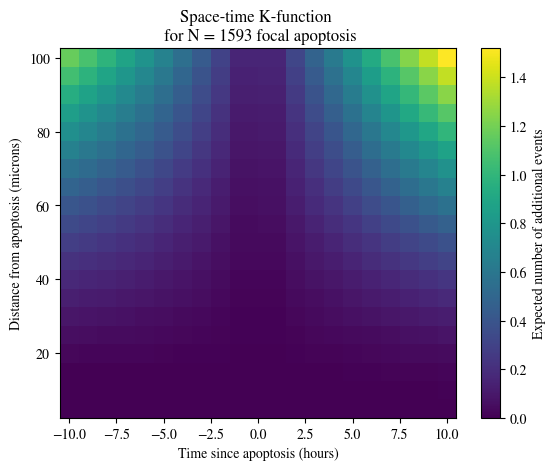

In [17]:
pc = plt.pcolormesh(delta_, h_, K_st, )
plt.colorbar(label = 'Expected number of additional events',)
plt.xlabel('Time since apoptosis (hours)')
plt.ylabel('Distance from apoptosis (microns)')
plt.title(f'Space-time K-function \n for N = {n2} focal apoptosis')

# Temporal indistinguishability test

Create a set of tau_ null hypotheses sets of events with randomly shifted time points from the original data frame

In [18]:
tau_ = range(0,1000)
for tau in tau_:
    ### create len(tau_) number of time permutations
    df[f'tpi τ = {tau}'] = df['tij'].sample(frac=1).reset_index(drop = True)

/var/folders/8x/6gc_8nk523n3ry7gdlxbfzgs3msxj9/T/ipykernel_99959/3651693006.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tpi τ = {tau}'] = df['tij'].sample(frac=1).reset_index(drop = True)
/var/folders/8x/6gc_8nk523n3ry7gdlxbfzgs3msxj9/T/ipykernel_99959/3651693006.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tpi τ = {tau}'] = df['tij'].sample(frac=1).reset_index(drop = True)
/var/folders/8x/6gc_8nk523n3ry7gdlxbfzgs3msxj9/T/ipykernel_99959/3651693006.py:4: PerformanceWarning: DataFrame is highly fragmented

/var/folders/8x/6gc_8nk523n3ry7gdlxbfzgs3msxj9/T/ipykernel_99959/3651693006.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tpi τ = {tau}'] = df['tij'].sample(frac=1).reset_index(drop = True)
/var/folders/8x/6gc_8nk523n3ry7gdlxbfzgs3msxj9/T/ipykernel_99959/3651693006.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tpi τ = {tau}'] = df['tij'].sample(frac=1).reset_index(drop = True)
/var/folders/8x/6gc_8nk523n3ry7gdlxbfzgs3msxj9/T/ipykernel_99959/3651693006.py:4: PerformanceWarning: DataFrame is highly fragmented

/var/folders/8x/6gc_8nk523n3ry7gdlxbfzgs3msxj9/T/ipykernel_99959/3651693006.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tpi τ = {tau}'] = df['tij'].sample(frac=1).reset_index(drop = True)
/var/folders/8x/6gc_8nk523n3ry7gdlxbfzgs3msxj9/T/ipykernel_99959/3651693006.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'tpi τ = {tau}'] = df['tij'].sample(frac=1).reset_index(drop = True)
/var/folders/8x/6gc_8nk523n3ry7gdlxbfzgs3msxj9/T/ipykernel_99959/3651693006.py:4: PerformanceWarning: DataFrame is highly fragmented

In [19]:
df

,index,Cell ID,dij,Frame,x,y,tij,Focal ID,tpi τ = 0,tpi τ = 1,...,tpi τ = 990,tpi τ = 991,tpi τ = 992,tpi τ = 993,tpi τ = 994,tpi τ = 995,tpi τ = 996,tpi τ = 997,tpi τ = 998,tpi τ = 999
0,6,169,100.000000,725,881,952,-3.200000,GV0794_Pos4_Scr_-73,-4.333333,-2.533333,...,-3.866667,3.400000,-3.866667,4.866667,6.666667,4.266667,7.600000,2.733333,0.466667,9.400000
1,8,173,99.666667,919,847,1365,9.733333,GV0794_Pos4_Scr_-73,4.200000,8.533333,...,-1.533333,7.533333,-0.666667,3.066667,-1.666667,2.333333,-7.333333,1.666667,-8.933333,8.666667
2,27,234,72.333333,771,914,1303,-0.133333,GV0794_Pos4_Scr_-73,5.000000,1.533333,...,-4.133333,-9.066667,-0.933333,9.666667,-9.600000,0.600000,-2.400000,-7.000000,7.266667,0.066667
3,28,235,40.666667,819,1005,1215,3.066667,GV0794_Pos4_Scr_-73,-6.333333,2.333333,...,-3.066667,3.466667,-1.533333,0.400000,-4.866667,3.200000,-6.400000,9.533333,-4.133333,3.866667
4,31,243,80.666667,763,934,1063,-0.666667,GV0794_Pos4_Scr_-73,9.466667,-9.933333,...,0.533333,3.400000,-1.466667,9.800000,-2.866667,-6.666667,-7.866667,5.666667,5.333333,6.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19806,398286,1442,92.000000,790,813,831,9.533333,GV0796_Pos7_Scr_-385,7.800000,7.333333,...,-9.533333,2.133333,-3.666667,1.600000,-3.266667,4.533333,8.000000,5.333333,8.400000,-4.200000
19807,398305,1504,81.666667,788,1008,867,9.400000,GV0796_Pos7_Scr_-385,-6.000000,9.466667,...,-1.200000,-4.933333,2.333333,9.466667,5.600000,-6.800000,2.800000,3.200000,9.666667,-7.133333
19808,398315,1525,66.333333,787,1046,814,9.333333,GV0796_Pos7_Scr_-385,-1.466667,-1.333333,...,-8.666667,-6.400000,5.000000,-7.800000,-7.266667,3.800000,0.600000,-9.266667,9.666667,-5.600000
19809,398323,1559,96.000000,722,1097,891,5.000000,GV0796_Pos7_Scr_-385,-4.466667,5.200000,...,-4.666667,-5.066667,9.133333,4.600000,8.400000,-2.466667,4.933333,9.400000,3.466667,0.466667


In [20]:
### create placeholder dict for each array of time permutation
K_st_tau_dict = {}

In [ ]:
for tau in tqdm(tau_, desc = 'Iterating over time permutations'):
    if tau in K_st_tau_dict:
        continue
    K_st_tau = np.zeros((len(h_), len(delta_)))  
    ### iterate over space
    for i, h in enumerate(h_):
        ### iterate over time
        for j, delta in enumerate(delta_):
            ### if no weighted count value stored then just assume all radial
            ### scans within fov so no weighting applies and just count normal
            if f'w({h, delta})' not in df:
                ### if delta is negative, then needs to be greater than or less than zero
                if delta < 0:
                    K_st_tau[i, j] = (1/(n * lambda_st)) * (len(df[((df[f'tpi τ = {tau}']) <= 0) & ((df[f'tpi τ = {tau}']) >= (delta)) & (df['dij'] <= h)]))
                ### if delta is positive, then has to be greater than zero less than delta
                else: 
                    K_st_tau[i, j] = (1/(n * lambda_st)) * (len(df[((df[f'tpi τ = {tau}']) >= 0) & ((df[f'tpi τ = {tau}']) <= (delta)) & (df['dij'] <= h)]))
            ### if there is a weighted value for that radii then count the instances of division as weighted values
            else: 
                ### if delta is negative, then needs to be greater than or less than zero
                if delta < 0:
                    K_st_tau[i, j] = (1/(n * lambda_st)) * sum(df[((df[f'tpi τ = {tau}']) <= 0) & ((df[f'tpi τ = {tau}']) >= (delta)) & (df['dij'] <= h)][f'w({h, delta})'])
                ### if delta is positive, then has to be greater than zero less than delta
                else: 
                    K_st_tau[i, j] = (1/(n * lambda_st)) * sum(df[((df[f'tpi τ = {tau}']) >= 0) & ((df[f'tpi τ = {tau}']) <= (delta)) & (df['dij'] <= h)][f'w({h, delta})'])
    K_st_tau_dict[tau] = K_st_tau
K_st_tau = K_st_tau_dict

Iterating over time permutations:   0%|          | 0/1000 [00:00<?, ?it/s]

# Save out k functions

In [93]:
with open(f'K_st_RAS_UNweighted_{max(h_)}um_{max(delta_)}hrs.{P_st_clust.shape}.pkl', 'wb') as f:
    pickle.dump(K_st, f)
with open(f'K_st_tau_1000_RAS_UNweighted_{max(h_)}um_{max(delta_)}hrs.{P_st_clust.shape}.pkl', 'wb') as f:
    pickle.dump(K_st_tau, f)

Loading previously calculated tau permutations from parallelised processes

In [17]:
with open('K_st_RAS_UNweighted_100.10.pkl', 'rb') as f:
    K_st = pickle.load(f)
with open('K_st_tau_1000_RAS_UNweighted_100.10.pkl', 'rb') as f:
    K_st_tau = pickle.load(f)

# Run p-value test

Checking to see if any two of the randomly time-indices-switched K-function arrays are identical (they should not be)

In [94]:
def arrays_equal(a, b):
    if a.shape != b.shape:
        return False
    for ai, bi in zip(a.flat, b.flat):
        if ai != bi:
            return False
    return True

In [95]:
len(K_st_tau)

1000

In [96]:
import itertools
from math import comb
for a, b in tqdm(itertools.combinations(K_st_tau, 2), total = comb(len(K_st_tau), 2)):
    array1 = K_st_tau[a]
    array2 = K_st_tau[b]
    if arrays_equal(array1, array2) == True:
        print(a, b, 'are equal')

  0%|          | 0/499500 [00:00<?, ?it/s]

In [97]:
N = len(K_st_tau)
P_st_clust = np.zeros(K_st.shape)
P_st_disp = np.zeros(K_st.shape)

for i, h in enumerate(tqdm(h_, total = len(h_))):
    for j, delta in enumerate(delta_):
        M0_plus = len([tau for tau in K_st_tau if K_st_tau[tau][i,j] >= K_st[i,j]])
        P_st_clust[i,j] = (M0_plus + 1)/(N+1)
        M0_minus = len([tau for tau in K_st_tau if K_st_tau[tau][i,j] <= K_st[i,j]])
        P_st_disp[i,j] = (M0_minus + 1)/(N+1)
    

  0%|          | 0/21 [00:00<?, ?it/s]

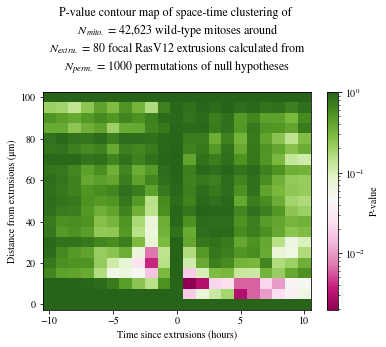

In [98]:
pc = plt.pcolormesh(delta_, h_, (P_st_clust), cmap = 'PiYG',  norm=colors.LogNorm(vmin=P_st_clust.min(), 
                                                                                  vmax=P_st_clust.max()))
plt.colorbar(label = 'P-value',)
plt.xlabel('Time since extrusions (hours)')
plt.ylabel('Distance from extrusions (μm)')
plt.title('P-value contour map of space-time clustering of \n $N_{mito.}$ = 42,623 wild-type mitoses around \n$N_{extru.}$ = 80 focal RasV12 extrusions calculated from \n$N_{perm.}$ = 1000 permutations of null hypotheses\n')
plt.savefig(f'k-function-final-results/RAS-UNweight-follow-p-value-log-division-clustering_{max(h_)}um_{max(delta_)}hrs.{P_st_clust.shape}.jpg', bbox_inches = 'tight', dpi = 314)

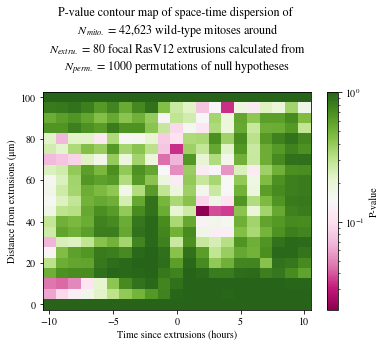

In [99]:
pc = plt.pcolormesh(delta_, h_, (P_st_disp), cmap = 'PiYG',  norm=colors.LogNorm(vmin=P_st_disp.min(), 
                                                                                  vmax=P_st_disp.max()))
plt.colorbar(label = 'P-value',)
plt.xlabel('Time since extrusions (hours)')
plt.ylabel('Distance from extrusions (μm)')
plt.title('P-value contour map of space-time dispersion of \n $N_{mito.}$ = 42,623 wild-type mitoses around \n$N_{extru.}$ = 80 focal RasV12 extrusions calculated from \n$N_{perm.}$ = 1000 permutations of null hypotheses\n')
plt.savefig(f'k-function-final-results/RAS-UNweight-follow-p-value-log-division-dispersion_{max(h_)}um_{max(delta_)}hrs.{P_st_clust.shape}.jpg', bbox_inches = 'tight', dpi = 314)